<a href="https://colab.research.google.com/github/Teriekarie/Presidential_Election_2023/blob/main/Nigeria_Election_2023.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Task

Extract data from twitter on the 3 presidential candidates (use their names to search for them), Remove any data that isnt talking about the perform a sentiment analysis on them, let us see who has the most polarity (positive tweets). To do this, calculate the average for each individual.

#Method

Using Twint to scrape tweets

Using Regex to clean tweets

Usin Textblob to obtain the sentiment of each tweet

Analyze and visualization

In [ ]:
#Uninstall twint
!pip uninstall twint

In [ ]:
#installing libraries

!pip install twint
!pip install Textblob --upgrade
!pip3 install --user --upgrade -e git+https://github.com/twintproject/twint.git@origin/master#egg=twint
!pip install pickle5

In [ ]:
pip install nest_asyncio

In [ ]:
pip install nltk

In [ ]:
!pip freeze

In [6]:
#importing libraries

import twint
import pandas as pd
import nest_asyncio             
import matplotlib.pyplot as plt

import pickle5 as pickle

import numpy as np
import datetime as dt
import seaborn as sns
import glob                     
import os

#cleaning
import re
from nltk.tokenize import WordPunctTokenizer
from nltk.corpus import stopwords             
import nltk
nltk.download('punkt')

# Sentiment Analysis
from textblob import TextBlob

#word cloud
from wordcloud import WordCloud

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


###Configure and set-up Twint

In [7]:
#for compatibility issues with twint
nest_asyncio.apply()

In [8]:
#create a dictionary of each candidate with its search names
#loop through the search names to twint and obtain tweet for each candidate
candidate_search = {"Peter Obi":"PeterObi OR \"peter obi\" OR \"PETEROBI\" OR \"peterobi\"",
"Bola Tinubu":"Jagaban OR Tinubu OR BolaTinubu","Atiku Abubakar":"ATIKU OR atiku OR ATIKUABUBAKAR"}

In [10]:
def twintConfig(search_string):
    c = twint.Config()
    c.Search = search_string[1]
    c.Limit= 2000
    c.Lang = 'en'
    c.Pandas = True
    c.Pandas_au = True          
    c.Pandas_clean=True
    c.Since='2022-01-01'
    c.Until='2022-11-30'
    #Config for file storage
    c.Store_csv = True  # To save tweets in a CSV format
    c.Output = "president.csv"
    twint.run.Search(c)

In [11]:
#run the twint through a function 
#with the candidate_search dictionary and concatenate the resulting dataframes
def Run_Twint(search_vals):
    
    #set empty dataframe for join
    out_df= pd.DataFrame()
    
    for candidate in search_vals.items():
        print ("running for search item: "+candidate[0]+"\n")
        print ("Search string: "+candidate[1]+"\n")
        
        #run twint
        twintConfig(candidate)
        
        #get dataframe from twint output
        tweets_df = twint.storage.panda.Tweets_df
        
        #join Dataframes and create 'Candidate' column
        tweets_df["Candidate"]= candidate[0]
        out_df = pd.concat([out_df,tweets_df])
        
    return out_df


In [ ]:
tweets_df = Run_Twint(candidate_search)

In [13]:
tweets_df.head()

,id,conversation_id,created_at,date,timezone,place,tweet,language,hashtags,cashtags,...,source,user_rt_id,user_rt,retweet_id,reply_to,retweet_date,translate,trans_src,trans_dest,Candidate
0,1597742167493324800,1597497317208526849,1.669766e+12,2022-11-29 23:59:52,+0000,,@agoyi44dogzy @oluwatonianu @_mustapher_ @TheN...,en,[],[],...,,,,,"[{'screen_name': 'agoyi44dogzy', 'name': 'Abdu...",,,,,Peter Obi
1,1597742166092435458,1597622080497147904,1.669766e+12,2022-11-29 23:59:51,+0000,,@_weyimi @Lexyzdoo @PeterObi.,qam,[],[],...,,,,,"[{'screen_name': '_weyimi', 'name': 'Weyimi B....",,,,,Peter Obi
2,1597742122480046080,1597270737118957571,1.669766e+12,2022-11-29 23:59:41,+0000,,@AntiXenophobian Thank God she has a gun. 😳,en,[],[],...,,,,,"[{'screen_name': 'AntiXenophobian', 'name': 'A...",,,,,Peter Obi
3,1597742080788680705,1597742080788680705,1.669766e+12,2022-11-29 23:59:31,+0000,,We are making unbelievable progress 🙌 thanks b...,en,[],[],...,,,,,[],,,,,Peter Obi
4,1597742003680575488,1597486726104363008,1.669766e+12,2022-11-29 23:59:12,+0000,,@alabiopeyemiola @officialABAT Your leader loo...,en,[],[],...,,,,,"[{'screen_name': 'alabiopeyemiola', 'name': 'A...",,,,,Peter Obi


#Precleaning

In [14]:
tweets_df.shape

(6026, 39)

In [15]:
tweets_df.columns

Index(['id', 'conversation_id', 'created_at', 'date', 'timezone', 'place',
       'tweet', 'language', 'hashtags', 'cashtags', 'user_id', 'user_id_str',
       'username', 'name', 'day', 'hour', 'link', 'urls', 'photos', 'video',
       'thumbnail', 'retweet', 'nlikes', 'nreplies', 'nretweets', 'quote_url',
       'search', 'near', 'geo', 'source', 'user_rt_id', 'user_rt',
       'retweet_id', 'reply_to', 'retweet_date', 'translate', 'trans_src',
       'trans_dest', 'Candidate'],
      dtype='object')

In [16]:
#Language analysis
#removing any language that is not english or undefined
tweets_df["language"].unique()

array(['en', 'qam', 'in', 'ht', 'es', 'und', 'tr', 'zxx', 'qme', 'tl',
       'art', 'qst', 'pt', 'hi', 'lv', 'it', 'da', 'ro', 'fr', 'et', 'cs',
       'sv', 'no', 'sl', 'pl', 'vi', 'nl', 'is', 'eu', 'cy', 'ca', 'lt',
       'de', 'ja', 'qht', 'ar', 'fi'], dtype=object)

In [17]:
# remove all rows where language is not english or undefined
tweets_df = tweets_df[tweets_df["language"].isin([ 'und', 'en'])]

In [18]:
#removing tweets from candidate's account
tweets_df = tweets_df[ ~tweets_df["username"].str.lower().str.contains('atiku|tinubu|peterobi|po|bolatinubu',regex = True)]

In [19]:
#Drop duplicated tweets 
tweets_df = tweets_df.drop_duplicates(subset=['date',"tweet","Candidate"],keep="first")

In [20]:
len(tweets_df)

5228

In [21]:
# Lowercase 
tweets_df['tweet']=tweets_df['tweet'].str.lower()
tweets_df.head()

,id,conversation_id,created_at,date,timezone,place,tweet,language,hashtags,cashtags,...,source,user_rt_id,user_rt,retweet_id,reply_to,retweet_date,translate,trans_src,trans_dest,Candidate
0,1597742167493324800,1597497317208526849,1.669766e+12,2022-11-29 23:59:52,+0000,,@agoyi44dogzy @oluwatonianu @_mustapher_ @then...,en,[],[],...,,,,,"[{'screen_name': 'agoyi44dogzy', 'name': 'Abdu...",,,,,Peter Obi
2,1597742122480046080,1597270737118957571,1.669766e+12,2022-11-29 23:59:41,+0000,,@antixenophobian thank god she has a gun. 😳,en,[],[],...,,,,,"[{'screen_name': 'AntiXenophobian', 'name': 'A...",,,,,Peter Obi
3,1597742080788680705,1597742080788680705,1.669766e+12,2022-11-29 23:59:31,+0000,,we are making unbelievable progress 🙌 thanks b...,en,[],[],...,,,,,[],,,,,Peter Obi
4,1597742003680575488,1597486726104363008,1.669766e+12,2022-11-29 23:59:12,+0000,,@alabiopeyemiola @officialabat your leader loo...,en,[],[],...,,,,,"[{'screen_name': 'alabiopeyemiola', 'name': 'A...",,,,,Peter Obi
6,1597741991990685696,1597733984041308160,1.669766e+12,2022-11-29 23:59:10,+0000,,@redmillennial @branditovox @victorshi2020 leg...,en,[],[],...,,,,,"[{'screen_name': 'redmillennial', 'name': '.',...",,,,,Peter Obi


#Cleaning Tweets

removing punctuations and symbols

In [22]:
#the function will take in a few patterns , such as links, @usernames, hashtags, numbers etc. 
#and replace these patterns with an empty string.

def clean_text(text):  
    pat1 = r'@[^ ]+'                   
    pat2 = r'https?://[A-Za-z0-9./]+'  
    pat3 = r'\'s'                      
    pat4 = r'\#\w+'                     
    pat5 = r'&amp '                     
    pat6 = r'[^A-Za-z\s]'               
    combined_pat = r'|'.join((pat1, pat2,pat3,pat4,pat5, pat6))
    text = re.sub(combined_pat,"",text).lower()
    return text.strip()

In [23]:
%%time
tweets_df["cleaned_tweet"] = tweets_df["tweet"].apply(clean_text)

CPU times: user 55.8 ms, sys: 805 µs, total: 56.6 ms
Wall time: 59.5 ms


In [24]:
#drop empty rows
tweets_df = tweets_df [ ~(tweets_df["tweet"] =="")]

In [25]:
tweets_df["cleaned_tweet"].head()

0    he invested so much in these sectors ive been ...
2                              thank god she has a gun
3    we are making unbelievable progress  thanks be...
4                 your leader looks tired and he limps
6      legal via scotus which can be overturned anyday
Name: cleaned_tweet, dtype: object

In [26]:
#converting and saving cleaned tweet


# converting to CSV file
tweets_df.to_csv("cleaned_presidential.csv")

In [27]:
# reset the index 
tweets_df.reset_index(drop= True,inplace=True)

#Sentiment Analysis

In [28]:
%%time
print("Running sentiment process")
for row in tweets_df.itertuples():
    tweet = tweets_df.at[row[0], 'cleaned_tweet']

    #run sentiment using TextBlob
    analysis = TextBlob(tweet)

    #set value to dataframe
    tweets_df.at[row[0], 'polarity'] = analysis.sentiment[0]
    tweets_df.at[row[0], 'subjectivity'] = analysis.sentiment[1]

    #Create Positive / negative column depending on polarity
    if analysis.sentiment[0]>0:
        tweets_df.at[row[0], 'Sentiment'] = "Positive"
    elif analysis.sentiment[0]<0:
        tweets_df.at[row[0], 'Sentiment'] = "Negative"
    else:
        tweets_df.at[row[0], 'Sentiment'] = "Neutral"

Running sentiment process
CPU times: user 1.69 s, sys: 1.92 ms, total: 1.69 s
Wall time: 1.7 s


In [29]:
tweets_df[["cleaned_tweet","polarity","Sentiment"]].head(5)

,cleaned_tweet,polarity,Sentiment
0,he invested so much in these sectors ive been ...,0.004167,Positive
1,thank god she has a gun,0.000000,Neutral
2,we are making unbelievable progress thanks be...,0.112500,Positive
3,your leader looks tired and he limps,-0.400000,Negative
4,legal via scotus which can be overturned anyday,0.200000,Positive


In [30]:
tweets_df.reset_index(drop = True,inplace=True)

#Analysis and visualization

In [31]:
#install additional libraries for visualisation 
import ast #optional
from collections import Counter

import cufflinks as cf
from plotly.offline import init_notebook_mode #, plot, iplot, download_plotlyjs
init_notebook_mode(connected = True)
cf.go_offline()

import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [32]:
# Set Pallette 
sns.set_theme()
pal = {"Peter Obi":'c', "Atiku Abubakar":"b","Bola Tinubu":"r"}

Candidate,Atiku Abubakar,Bola Tinubu,Peter Obi
cleaned_tweet,1655,1815,1758


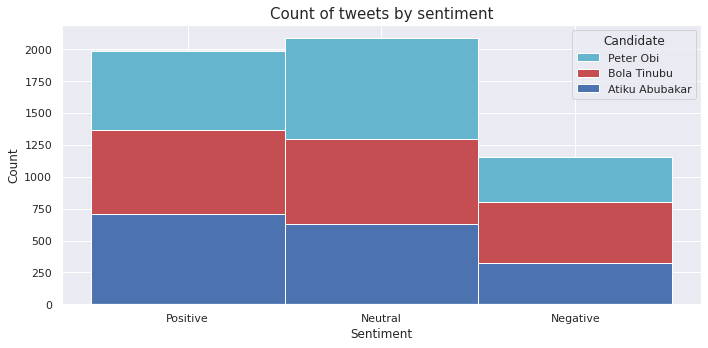

In [33]:
display(tweets_df[["cleaned_tweet","Candidate"]].groupby(["Candidate"]).count().transpose())

plt.figure(figsize=(10,5))
sns.histplot(tweets_df, x="Sentiment", hue="Candidate", palette= pal, multiple="stack", alpha = 1)
plt.title("Count of tweets by sentiment",fontsize =15)

plt.tight_layout()
plt.show()

In [70]:
# Saving the figure.
plt.savefig("tweets.jpg")

<Figure size 432x288 with 0 Axes>

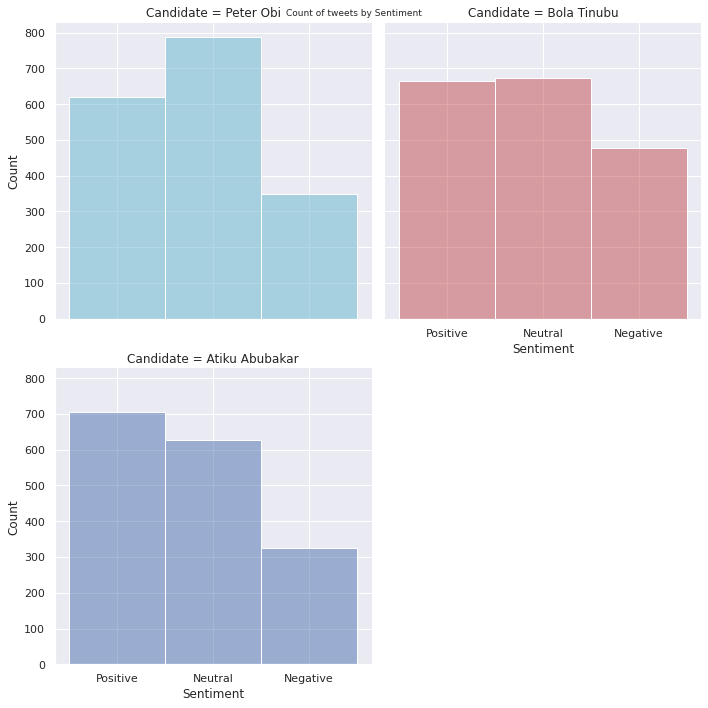

In [36]:
fig1 = sns.displot(tweets_df, x="Sentiment", col="Candidate",col_wrap= 2, hue="Candidate", legend=False, palette= pal)
fig1.fig.suptitle("Count of tweets by Sentiment",fontsize =9)

plt.tight_layout()
plt.show()

In [69]:
# Saving the figure.
plt.savefig("Sentiment.jpg")

<Figure size 432x288 with 0 Axes>

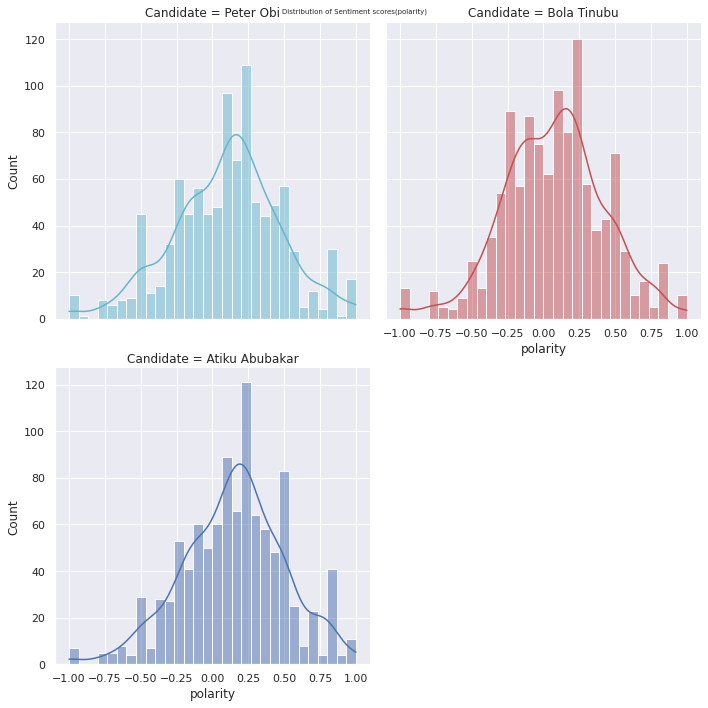

In [37]:
fig1 = sns.displot(data = tweets_df[~(tweets_df['polarity']==0)], x="polarity",
                   col="Candidate",
                   col_wrap= 2, 
                   hue="Candidate", 
                   legend=False, 
                   palette= pal,
                   kde = True,
                   bins =30)
fig1.fig.suptitle("Distribution of Sentiment scores(polarity)",fontsize =7 )

plt.tight_layout()
plt.show()

In [68]:
# Saving the figure.
plt.savefig("Polarity.jpg")

<Figure size 432x288 with 0 Axes>

#Hashtag Analysis

In [38]:
tweets_df["date"] = pd.to_datetime(tweets_df["date"])

#set index = date so as to create rolling mean 
tweets_df = tweets_df.sort_values("date").set_index("date")

In [39]:
#Create candidates Dataframes 
PeterObi_df = tweets_df[(tweets_df.Candidate=="PeterObi")]
Atiku_df = tweets_df[(tweets_df.Candidate=="AtikuAbubakar")]
Tinubu_df = tweets_df[(tweets_df.Candidate=="BolaTinubu")]

In [40]:
#get all hashtags as list
def hashlist(df):
    hashlist = []
    for i in df['hashtags']:
        #use ast.literal if you are importing CSV files otherwise just use 'i'
        hashlist.extend(ast.literal_eval(i))
    return hashlist

In [ ]:
#Create hashtag dataframes
hash_PeterObi= pd.DataFrame(Counter(hashlist(PeterObi_df)).items()).sort_values(1,ascending=False)
hash_Atiku= pd.DataFrame(Counter(hashlist(Atiku_df)).items()).sort_values(1,ascending=False)
hash_Tinubu= pd.DataFrame(Counter(hashlist(Tinubu_df)).items()).sort_values(1,ascending=False)

#Wordcloud

In [71]:
# Load NLTK library
#Langauage processing libraries
import nltk

# Download the stopwords to the nltk library
nltk.download('stopwords')

# Load the stopwords
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [72]:
# get the list of all stopwords from the library (Language - 'en')
stop = stopwords.words('english')
print(stop)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [75]:
# Removing the words in 'stop' list
def remove_stop_words(tweet):
  tokens = tweet.split()
  stop_removed_tokens = [t for t in tokens if t not in stop]
  convert_to_string = " ".join(stop_removed_tokens)
  return convert_to_string
  
tweets_df['tweet'] = tweets_df['tweet'].apply(remove_stop_words)
tweets_df.tail(5)

,id,conversation_id,created_at,timezone,place,tweet,language,hashtags,cashtags,user_id,...,reply_to,retweet_date,translate,trans_src,trans_dest,Candidate,cleaned_tweet,polarity,subjectivity,Sentiment
date,,,,,,,,,,,,,,,,,,,,,
2022-11-29 23:59:12,1597742003680575488,1597486726104363008,1.669766e+12,+0000,,@alabiopeyemiola @officialabat leader looks ti...,en,[],[],1382809564865761280,...,"[{'screen_name': 'alabiopeyemiola', 'name': 'A...",,,,,Peter Obi,your leader looks tired and he limps,-0.400000,0.700000,Negative
2022-11-29 23:59:20,1597742034596642816,1597742034596642816,1.669766e+12,+0000,,"ever feel useless, remember there’s somebody d...",en,[],[],1408376971743088646,...,[],,,,,Bola Tinubu,when ever you feel useless just remember there...,-0.250000,0.216667,Negative
2022-11-29 23:59:31,1597742080788680705,1597742080788680705,1.669766e+12,+0000,,"making unbelievable progress 🙌 thanks god, ota...",en,[],[],1461835592,...,[],,,,,Peter Obi,we are making unbelievable progress thanks be...,0.112500,0.675000,Positive
2022-11-29 23:59:41,1597742122480046080,1597270737118957571,1.669766e+12,+0000,,@antixenophobian thank god gun. 😳,en,[],[],1387751095037005827,...,"[{'screen_name': 'AntiXenophobian', 'name': 'A...",,,,,Peter Obi,thank god she has a gun,0.000000,0.000000,Neutral
2022-11-29 23:59:52,1597742167493324800,1597497317208526849,1.669766e+12,+0000,,@agoyi44dogzy @oluwatonianu @_mustapher_ @then...,en,[],[],181527564,...,"[{'screen_name': 'agoyi44dogzy', 'name': 'Abdu...",,,,,Peter Obi,he invested so much in these sectors ive been ...,0.004167,0.566667,Positive


In [76]:
tweetString_a = " ".join(list(PeterObi_df["cleaned_tweet"])).lower()
tweetString_n = " ".join(list(Atiku_df["cleaned_tweet"])).lower()
tweetString_s = " ".join(list(Tinubu_df["cleaned_tweet"])).lower()

In [77]:
# Creating a word frequency series
#(This is a **pandas** series)
word_frequency = pd.Series(' '.join(tweets_df['tweet']).split()).value_counts()

In [79]:
# Display top 10 words
word_frequency[:10]

tinubu       1802
@peterobi    1248
atiku        1147
obi          1086
peter         906
@fkeyamo      520
@atiku        477
vote          449
debate        387
go            376
dtype: int64

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



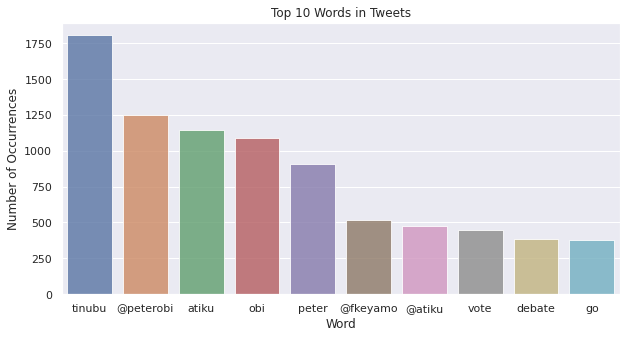

In [83]:
# Visualizing the top 10 word counts 

word_count  = word_frequency
word_count = word_count[:10,]
plt.figure(figsize=(10,5))
sns.barplot(word_count.index, word_count.values, alpha=0.8)
plt.title('Top 10 Words in Tweets')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Word', fontsize=12)
plt.show()

In [80]:
from PIL import Image
from wordcloud import WordCloud

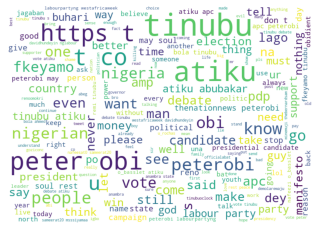

In [81]:
#Visualizing text corpus
corpus = list(tweets_df['tweet'])
wordcloud = WordCloud(background_color='white', max_words=200, max_font_size=70, random_state=42, width = 700, height = 500).generate(str(corpus))
# WordCloud(collocations = False,max_words=200, background_color = 'white', width = 7000, height = 5000).generate(tweets_string)


fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [82]:
#saving the word cloud image
wordcloud.to_file("wordcloud.png")

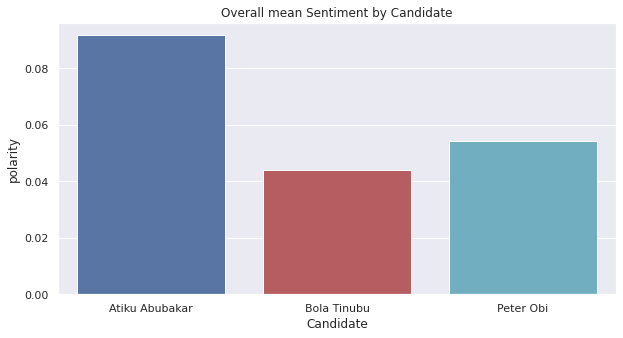

In [57]:
# Overall mean sentiment by candidate
plt.figure(figsize=(10,5))
plt.title("Overall mean Sentiment by Candidate")
sns.barplot(data = tweets_df, x= "Candidate", y = "polarity", palette=pal, ci=False)
plt.show()

#Rolling point

In [59]:
#Std Bank
PeterObi_df['mean'] = PeterObi_df['polarity'].expanding().mean()
PeterObi_df['rolling'] = PeterObi_df['polarity'].rolling("7d").mean()

#FNB
Tinubu_df['mean'] = Tinubu_df['polarity'].expanding().mean()
Tinubu_df['rolling'] = Tinubu_df['polarity'].rolling("7d").mean()

#Nebank
Atiku_df['mean'] = Atiku_df['polarity'].expanding().mean()
Atiku_df['rolling'] = Atiku_df['polarity'].rolling("7d").mean()

In [60]:
# functions to create our graphs
def trace_rolling_creation(df,gname, glinecolor):
    return fig.add_trace(
        go.Scatter(
            x= df.index, 
            y=df["rolling"], 
            name=gname,  
            mode='lines',
            line_color=glinecolor),
        secondary_y=False
)

def trace_count_creation(df,gname, glinecolor):
    return fig.add_trace(
        go.Scatter(
            x= df.index, 
            y=df["polarity"].rolling('7d').count(), 
            name=gname,  
            fill='tozeroy',line_color=glinecolor), 
        secondary_y=True
)

In [ ]:
# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add traces
trace_rolling_creation(Tinubu_df, "Tinubu", '#DC0E1A')
trace_rolling_creation(Atiku_df, "Atiku", '#078a4d')
trace_rolling_creation(PeterObi_df, "PeterObi", '#054db3')

trace_count_creation(Tinubu_df, "Tinubu", 'rgb(220, 14, 26)')
trace_count_creation(Atiku_df, "Atiku", 'rgb(7, 138, 77)')
trace_count_creation(PeterObi_df, "PeterObi", 'rgb(5, 77, 179)')

# set figure layout
fig.update_layout(
    template = "seaborn",
    title_text="Rolling 7d Sentiment vs Count of tweets",
    legend_title="Candidate",
    font=dict(size=12),
    autosize=False,
    width=1000,
    height=600,
    margin=dict (l=10,r=10,b=50,t=50, pad=2)
)

# Set x-axis title
fig.update_xaxes(title_text="Date")

# Set y-axes titles
fig.update_yaxes(title_text="Rolling",range = [-0.1,0.4], secondary_y=False)
fig.update_yaxes(title_text="Count",range = [0,40000], secondary_y=True)

fig.show()

#Summary

This project is based on the tweets from 2022-01-01 to 2022-11-30 in real time

We use Twint to scrape the data from twitter which amounted to (6026, 39) then went on to clean and make necessary adjustments on the dataframe.

The Language was analyzed and restricted to just English whilst droping the other undefined languages

The sentimental analysis here shows that Bola tinubu has more on the negative response compared to the other candidates followed by Atiku then Peterobi. Peter obi has more neutral tweets than the other candidates as well as more Positive tweets which is closly follwed by Atiku.

It is then safe to say that Peter Obi is most talked about on twitter.

An Hashtag analysis was carried out to show the most trending hashtags of each candidates.

W also ran a word frequency to see the most mentioned word in the tweets and visualised the top ten having Tinubu leading the chart followed by Peter Obi and then Atiku. You can see that Peter obi is still showing with other associated terms. these words were then displayed in the wordcloud.

Finally, we got the overall sentiment of the tweets for each candidate.

In conclusion, please note that the data is based on what the system classify as sentimental as per the wordings in the tweets.

